---

# Machine Learning

---

## Objective

This notebook extends the previous exploratory analysis to develop a machine learning model aimed at classifying users based on their primary app usage type: Social Media, Gaming, or Productivity. By leveraging behavioral and demographic features, the model seeks to accurately categorize users, providing valuable insights into app usage patterns across different user segments. After testing multiple models, including Random Forest and XGBoost, XGBoost emerged as the top performer with an accuracy of 96%, slightly surpassing Random Forest, which achieved an accuracy of 95%. This slight improvement demonstrates XGBoost’s ability to capture subtle patterns in the data, making it the final model choice for this analysis.

## Introduction

In the initial exploratory analysis, various trends were observed in users' app usage habits, with specific demographic groups displaying distinct preferences for Social Media, Gaming, or Productivity apps. To capture these patterns and predict a user’s primary app usage type, we considered key features such as Productivity_App_Usage_Hours, Social_Media_Usage_Hours, Gaming_App_Usage_Hours, Age_Group, and Time_of_Day.

The model selection process involved testing several algorithms to balance interpretability, performance, and adaptability to the dataset's high dimensionality. Initially, the Random Forest classifier showed strong performance, achieving an accuracy of 95%, thanks to its capability to handle complex feature interactions and provide feature importance insights. However, we observed a slight accuracy improvement with the XGBoost model, which reached 96%. XGBoost's enhanced accuracy is likely due to its boosted approach, which sequentially corrects errors from previous models, making it particularly effective in capturing intricate patterns in high-dimensional data.


### Initial Data Exploration/Cleaning

In [149]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import pearsonr, spearmanr, f_oneway, kruskal

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize

# Machine Learning and Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Statsmodels for Advanced Statistical Modeling
import statsmodels.api as sm

# Clustering (Optional, if needed in the project)
from sklearn.cluster import KMeans

In [150]:
mobile_usage_beh= pd.read_csv('Data\mobile_usage_behavioral_analysis.csv', index_col=0)

In [151]:
data = mobile_usage_beh.reset_index(drop=False)
data.head(10)

,User_ID,Age,Gender,Total_App_Usage_Hours,Daily_Screen_Time_Hours,Number_of_Apps_Used,Social_Media_Usage_Hours,Productivity_App_Usage_Hours,Gaming_App_Usage_Hours,Location
0,1,56,Male,2.61,7.15,24,4.43,0.55,2.40,Los Angeles
1,2,46,Male,2.13,13.79,18,4.67,4.42,2.43,Chicago
2,3,32,Female,7.28,4.50,11,4.58,1.71,2.83,Houston
3,4,25,Female,1.20,6.29,21,3.18,3.42,4.58,Phoenix
4,5,38,Male,6.31,12.59,14,3.15,0.13,4.00,New York
5,6,56,Female,3.31,1.04,21,2.02,3.45,2.26,Chicago
6,7,36,Male,4.81,1.52,24,3.76,1.58,3.59,Los Angeles
7,8,40,Male,9.53,8.85,11,2.66,0.28,2.93,Chicago
8,9,28,Male,11.35,12.80,9,3.39,3.05,2.46,Phoenix
9,10,28,Male,1.80,4.11,16,2.14,1.20,0.96,New York


In [152]:
print(mobile_usage_beh.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           1000 non-null   int64  
 1   Gender                        1000 non-null   object 
 2   Total_App_Usage_Hours         1000 non-null   float64
 3   Daily_Screen_Time_Hours       1000 non-null   float64
 4   Number_of_Apps_Used           1000 non-null   int64  
 5   Social_Media_Usage_Hours      1000 non-null   float64
 6   Productivity_App_Usage_Hours  1000 non-null   float64
 7   Gaming_App_Usage_Hours        1000 non-null   float64
 8   Location                      1000 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 78.1+ KB
None


In [153]:
print(mobile_usage_beh.describe())

               Age  Total_App_Usage_Hours  Daily_Screen_Time_Hours  \
count  1000.000000            1000.000000              1000.000000   
mean     38.745000               6.405670                 7.696310   
std      12.186734               3.134855                 3.714187   
min      18.000000               1.000000                 1.010000   
25%      28.000000               3.590000                 4.530000   
50%      40.000000               6.455000                 7.880000   
75%      50.000000               9.122500                10.910000   
max      59.000000              11.970000                14.000000   

       Number_of_Apps_Used  Social_Media_Usage_Hours  \
count           1000.00000               1000.000000   
mean              16.64700                  2.456330   
std                7.61961                  1.439525   
min                3.00000                  0.000000   
25%               10.00000                  1.200000   
50%               17.00000       

---

# Data Preprocessing

---

In [154]:

data['Social_Media_Use'] = data['Social_Media_Usage_Hours']/(data['Social_Media_Usage_Hours'] + data['Productivity_App_Usage_Hours'] + data['Gaming_App_Usage_Hours'])*100
data['Productivity_App_Use'] = data['Productivity_App_Usage_Hours']/(data['Social_Media_Usage_Hours'] + data['Productivity_App_Usage_Hours'] + data['Gaming_App_Usage_Hours'])*100
data['Gaming_App_Use'] = data['Gaming_App_Usage_Hours']/(data['Social_Media_Usage_Hours'] + data['Productivity_App_Usage_Hours'] + data['Gaming_App_Usage_Hours'])*100
data.head(10)

,User_ID,Age,Gender,Total_App_Usage_Hours,Daily_Screen_Time_Hours,Number_of_Apps_Used,Social_Media_Usage_Hours,Productivity_App_Usage_Hours,Gaming_App_Usage_Hours,Location,Social_Media_Use,Productivity_App_Use,Gaming_App_Use
0,1,56,Male,2.61,7.15,24,4.43,0.55,2.40,Los Angeles,60.027100,7.452575,32.520325
1,2,46,Male,2.13,13.79,18,4.67,4.42,2.43,Chicago,40.538194,38.368056,21.093750
2,3,32,Female,7.28,4.50,11,4.58,1.71,2.83,Houston,50.219298,18.750000,31.030702
3,4,25,Female,1.20,6.29,21,3.18,3.42,4.58,Phoenix,28.443649,30.590340,40.966011
4,5,38,Male,6.31,12.59,14,3.15,0.13,4.00,New York,43.269231,1.785714,54.945055
5,6,56,Female,3.31,1.04,21,2.02,3.45,2.26,Chicago,26.131953,44.631307,29.236740
6,7,36,Male,4.81,1.52,24,3.76,1.58,3.59,Los Angeles,42.105263,17.693169,40.201568
7,8,40,Male,9.53,8.85,11,2.66,0.28,2.93,Chicago,45.315162,4.770017,49.914821
8,9,28,Male,11.35,12.80,9,3.39,3.05,2.46,Phoenix,38.089888,34.269663,27.640449
9,10,28,Male,1.80,4.11,16,2.14,1.20,0.96,New York,49.767442,27.906977,22.325581


In [155]:
mobile_usage_beh.reset_index(drop=False)['Location'].unique()

array(['Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'New York'],
      dtype=object)

In [156]:
age_bins = [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]
age_labels = ['18-22', '23-27', '28-32', '33-37', '38-42', '43-47', '48-52', '53-57', '58-62']


data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)

# Calculate average daily usage time for each age group
average_daily_usage_by_age_group = data.groupby(['Age_Group'])['Number_of_Apps_Used'].mean()


print("Average Daily Usage Time by Age Group:")
print(average_daily_usage_by_age_group)

Average Daily Usage Time by Age Group:
Age_Group
18-22    16.519380
23-27    16.101852
28-32    17.687500
33-37    17.088235
38-42    16.178862
43-47    16.317829
48-52    16.893939
53-57    16.551181
58-62    16.473684
Name: Number_of_Apps_Used, dtype: float64


In [157]:
data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)
usage_by_demo = data.groupby(['Gender', 'Age_Group', 'Location'])[['Social_Media_Use', 'Productivity_App_Use', 'Gaming_App_Use']].mean()


In [158]:
# Selecting the columns for clustering
cluster_data = data[['Social_Media_Use', 'Productivity_App_Use', 'Gaming_App_Use']].copy()

# Standardizing the data to have zero mean and unit variance
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Performing K-Means clustering with an arbitrary number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_data['Cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Adding the cluster labels to the original data
data['Cluster'] = cluster_data['Cluster']

# Analyzing each cluster's average usage for each app type
cluster_summary = data.groupby('Cluster')[['Social_Media_Use', 'Productivity_App_Use', 'Gaming_App_Use']].mean()



c:\Users\Elif Surucu\anaconda3\envs\Cohort_Env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [159]:
cluster_summary = pd.DataFrame({
    'Cluster': [0, 1, 2],
    'Social_Media_Use': [22.70, 53.29, 23.81],
    'Productivity_App_Use': [27.81, 21.83, 56.23],
    'Gaming_App_Use': [49.47, 24.87, 19.95]
})


cluster_summary_melted = cluster_summary.melt(id_vars="Cluster", 
                                              var_name="App Type", 
                                              value_name="Average Usage (%)")


In [160]:
#Operations performed to analyze the demographic characteristics of each cluster obtained as a result of cluster analysis
demographic_summary = data.groupby('Cluster')[['Age', 'Gender', 'Location']].value_counts(normalize=True).unstack().fillna(0)

In [161]:
# Calculating gender distribution within each cluster
gender_distribution = data.groupby(['Cluster', 'Gender']).size().unstack().fillna(0)
gender_distribution = gender_distribution.div(gender_distribution.sum(axis=1), axis=0)

In [162]:
# Calculating location distribution within each cluster
location_distribution = data.groupby(['Cluster', 'Location']).size().unstack().fillna(0)
location_distribution = location_distribution.div(location_distribution.sum(axis=1), axis=0)


In [163]:
np.random.seed(42) 
data['Hour'] = np.random.randint(0, 24, size=len(data))
data.head(20)

,User_ID,Age,Gender,Total_App_Usage_Hours,Daily_Screen_Time_Hours,Number_of_Apps_Used,Social_Media_Usage_Hours,Productivity_App_Usage_Hours,Gaming_App_Usage_Hours,Location,Social_Media_Use,Productivity_App_Use,Gaming_App_Use,Age_Group,Cluster,Hour
0,1,56,Male,2.61,7.15,24,4.43,0.55,2.40,Los Angeles,60.027100,7.452575,32.520325,53-57,1,6
1,2,46,Male,2.13,13.79,18,4.67,4.42,2.43,Chicago,40.538194,38.368056,21.093750,43-47,1,19
2,3,32,Female,7.28,4.50,11,4.58,1.71,2.83,Houston,50.219298,18.750000,31.030702,28-32,1,14
3,4,25,Female,1.20,6.29,21,3.18,3.42,4.58,Phoenix,28.443649,30.590340,40.966011,23-27,0,10
4,5,38,Male,6.31,12.59,14,3.15,0.13,4.00,New York,43.269231,1.785714,54.945055,38-42,0,7
5,6,56,Female,3.31,1.04,21,2.02,3.45,2.26,Chicago,26.131953,44.631307,29.236740,53-57,2,20
6,7,36,Male,4.81,1.52,24,3.76,1.58,3.59,Los Angeles,42.105263,17.693169,40.201568,33-37,1,6
7,8,40,Male,9.53,8.85,11,2.66,0.28,2.93,Chicago,45.315162,4.770017,49.914821,38-42,0,18
8,9,28,Male,11.35,12.80,9,3.39,3.05,2.46,Phoenix,38.089888,34.269663,27.640449,28-32,1,22
9,10,28,Male,1.80,4.11,16,2.14,1.20,0.96,New York,49.767442,27.906977,22.325581,28-32,1,10


In [164]:
np.random.seed(0)
data_sorted = pd.DataFrame({
    'Age': np.random.randint(18, 60, 100), 
    'Gender': np.random.choice(['Male', 'Female'], 100),  
    'Daily_Screen_Time_Hours': np.random.uniform(5, 10, 100) })
data_sorted

,Age,Gender,Daily_Screen_Time_Hours
0,18,Female,8.298342
1,21,Male,7.666031
2,21,Male,6.152665
3,57,Female,6.974346
4,27,Male,8.094043
...,...,...,...
95,48,Female,9.407927
96,18,Male,9.522125
97,54,Female,8.228923
98,52,Male,6.623415


In [165]:
data_sorted['Age_Group'] = pd.cut(data_sorted['Age'], bins=[10, 20, 30, 40, 50, 60, 70], labels=["10-20", "20-30", "30-40", "40-50", "50-60", "60-70"])

#Average daily screen time by age groups and gender
age_grouped_data = data_sorted.groupby(['Age_Group', 'Gender'])['Daily_Screen_Time_Hours'].mean().reset_index()


In [166]:
# Generating random timestamp data for 'Usage_Time' column
np.random.seed(0)  # For reproducibility
data['Usage_Time'] = pd.to_datetime(
    '2023-01-01') + pd.to_timedelta(np.random.randint(0, 86400, data.shape[0]), unit='s')



In [167]:
np.random.seed(0)  # Reproducibility için sabit tohum
data['Usage_Time'] = pd.to_datetime(
    '2023-01-01') + pd.to_timedelta(np.random.randint(0, 86400, data.shape[0]), unit='s')

In [168]:

data['Usage_Hour'] = data['Usage_Time'].dt.hour


In [169]:
data['Time_of_Day'] = pd.cut(data['Usage_Time'].dt.hour,
                              bins=[0, 6, 12, 18, 24],
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                              right=False)

### Random Forest

In [170]:
data = data.drop(columns=['Usage_Time'])

In [171]:
data['Type_of_Use'] = data[['Social_Media_Usage_Hours', 'Productivity_App_Usage_Hours', 'Gaming_App_Usage_Hours']].idxmax(axis=1)
data['Type_of_Use'] = data['Type_of_Use'].map({
    'Social_Media_Usage_Hours': 'Social Media',
    'Productivity_App_Usage_Hours': 'Productivity',
    'Gaming_App_Usage_Hours': 'Gaming'
})

In [172]:

data_encoded = pd.get_dummies(data, columns=['Gender', 'Location', 'Age_Group', 'Time_of_Day'], drop_first=True)
label_encoder = LabelEncoder()
data_encoded['Type_of_Use'] = label_encoder.fit_transform(data['Type_of_Use'])

# Define the properties (X) and target variable (y)
X = data_encoded.drop(columns=['Type_of_Use'])
y = data_encoded['Type_of_Use']

# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Train the model

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# Making predictions and evaluations
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Feature Importance Values
importances = model.feature_importances_
feature_names = X_train.columns
sorted_idx = importances.argsort()

Model Accuracy: 0.95


Random Forest model has achieved an accuracy of 0.95

C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_4396\1184808324.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


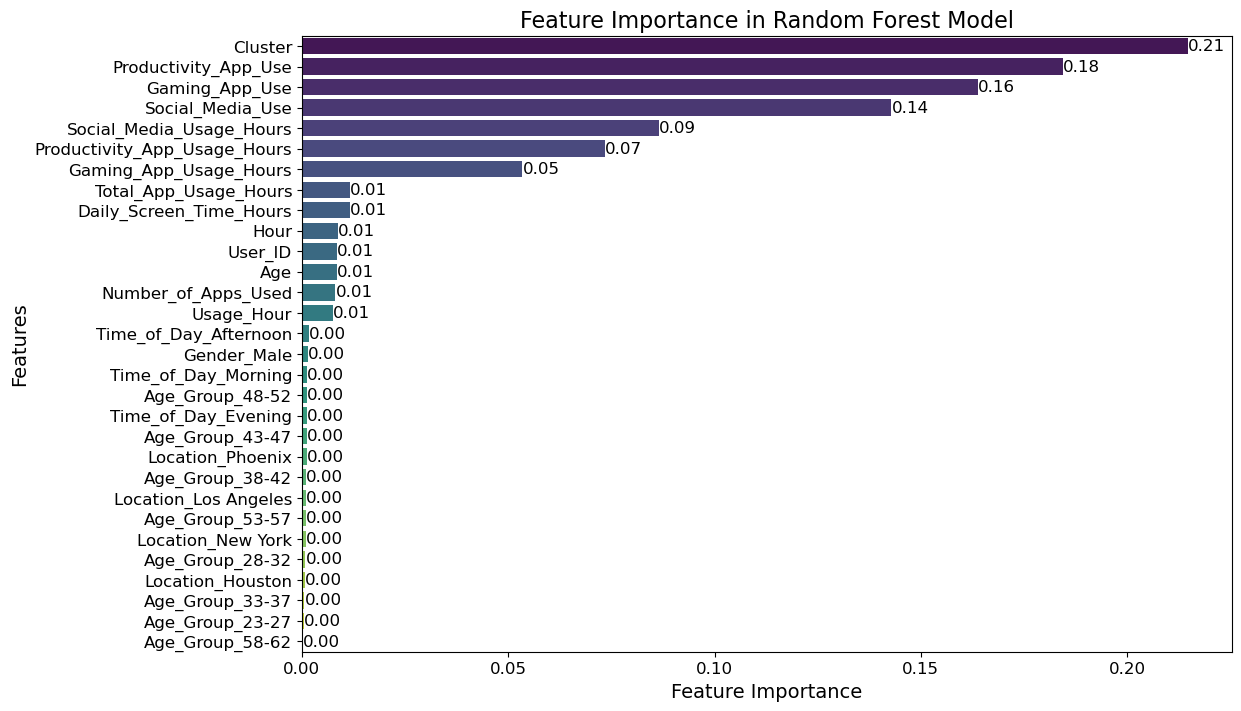

In [ ]:
plt.figure(figsize=(12, 8))
sorted_idx = importances.argsort()[::-1]
sns.barplot(
    x=importances[sorted_idx],
    y=feature_names[sorted_idx],
    palette="viridis" 
)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Feature Importance in Random Forest Model", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(importances[sorted_idx]):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left', fontsize=12)

plt.show()

Among the most important features, Cluster, Productivity_App_Use, Gaming_App_Use, Social_Media_Use, and Social_Media_Usage_Hours stand out. This indicates that the model gives more weight to these features when making predictions.

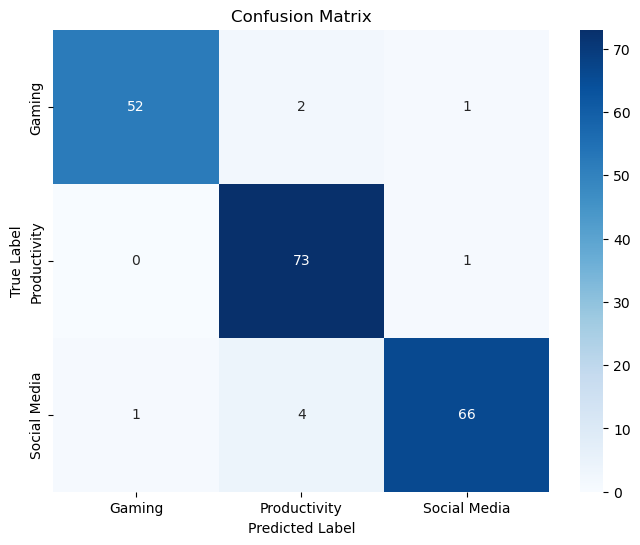

In [174]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Classification Report:
              precision    recall  f1-score   support

      Gaming       0.98      0.95      0.96        55
Productivity       0.92      0.99      0.95        74
Social Media       0.97      0.93      0.95        71

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.96       200
weighted avg       0.96      0.95      0.96       200



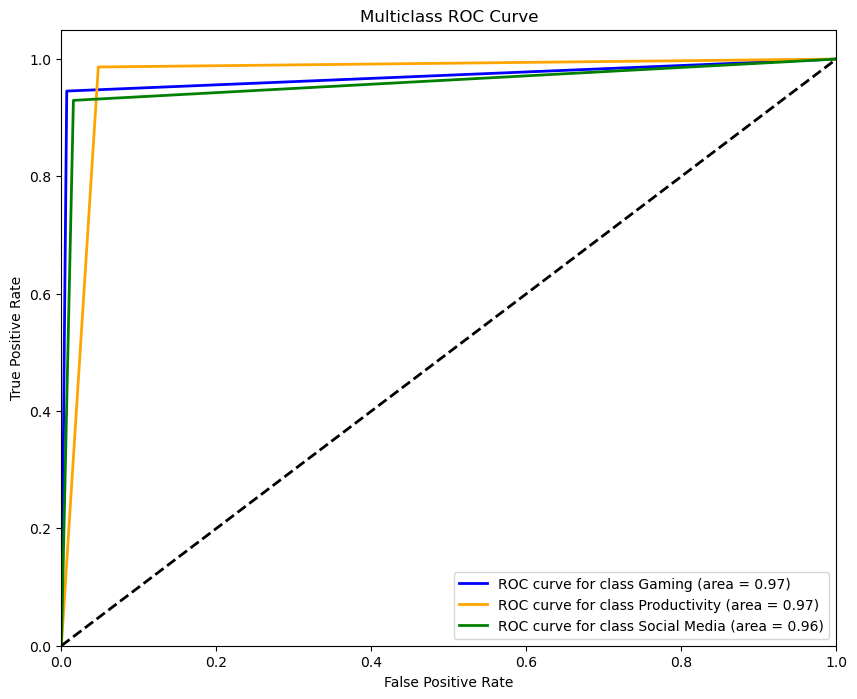

In [175]:
# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(classification_rep)

# Binarize the labels for multiclass ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2 for Gaming, Productivity, Social Media
y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2])

# Calculate ROC AUC for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve for class {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()


Classification report and ROC curve indicate a strong model performance, with high precision, recall, and F1-scores across all classes. Each class has a high AUC score, suggesting excellent discrimination power.

In [176]:
importances = model.feature_importances_
feature_names = X_train.columns
importance_data = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [177]:
!pip install imbalanced-learn

In [178]:
from imblearn.over_sampling import RandomOverSampler

# Initialize the resampler
ros = RandomOverSampler(random_state=42)

# Resample X and y
X_resampled, y_resampled = ros.fit_resample(X, y)

In [179]:
import pandas as pd

# Before resampling
class_distribution_before = y.value_counts().sort_index()
class_distribution_data_before = pd.DataFrame({
    'Class': class_distribution_before.index,
    'Count': class_distribution_before.values,
    'Stage': 'Before Resampling'
})

# After resampling
class_distribution_after = pd.Series(y_resampled).value_counts().sort_index()
class_distribution_data_after = pd.DataFrame({
    'Class': class_distribution_after.index,
    'Count': class_distribution_after.values,
    'Stage': 'After Resampling'
})

# Combine the two DataFrames for plotting
class_distribution_data = pd.concat([class_distribution_data_before, class_distribution_data_after])


In [180]:
# Before resampling
class_distribution_before = y.value_counts().sort_index()
class_distribution_data_before = pd.DataFrame({
    'Class': class_distribution_before.index,
    'Count': class_distribution_before.values,
    'Stage': 'Before Resampling'
})

# After resampling (assuming y_resampled is your resampled target variable)
class_distribution_after = y_resampled.value_counts().sort_index()
class_distribution_data_after = pd.DataFrame({
    'Class': class_distribution_after.index,
    'Count': class_distribution_after.values,
    'Stage': 'After Resampling'
})

# Combine the two DataFrames for plotting
class_distribution_data = pd.concat([class_distribution_data_before, class_distribution_data_after])


C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_4396\3982113164.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=colors)
C:\Users\Elif Surucu\AppData\Local\Temp\ipykernel_4396\3982113164.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette=colors)


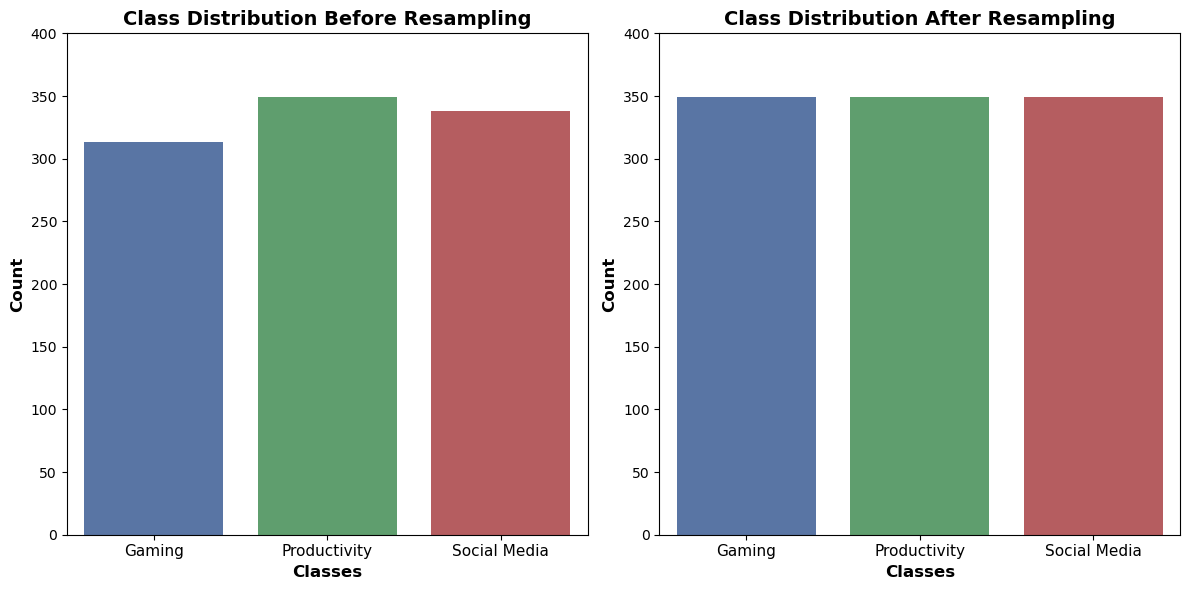

In [181]:

class_names = ["Gaming", "Productivity", "Social Media"]
colors = ["#4c72b0", "#55a868", "#c44e52"]  

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
sns.countplot(x=y, palette=colors)
plt.title("Class Distribution Before Resampling", fontsize=14, fontweight='bold')
plt.xlabel("Classes", fontsize=12, fontweight='bold')
plt.ylabel("Count", fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1, 2], labels=class_names, fontsize=11)
plt.ylim(0, 400)


plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, palette=colors)
plt.title("Class Distribution After Resampling", fontsize=14, fontweight='bold')
plt.xlabel("Classes", fontsize=12, fontweight='bold')
plt.ylabel("Count", fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1, 2], labels=class_names, fontsize=11)
plt.ylim(0, 400)


plt.tight_layout()
plt.show()

###  XGBoost Modeling

In [182]:
#Preparatory work on using the XGBoost model with SHAP (SHapley Additive exPlanations) to analyze the explainability of the machine learning model

!pip install shap


In [183]:
!pip install xgboost

In [184]:
!pip show xgboost

Name: xgboost
Version: 2.1.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: c:\users\elif surucu\anaconda3\envs\cohort_env\lib\site-packages
Requires: numpy, scipy
Required-by: 


To test the XGBoost model

In [185]:
X = data_encoded.drop(columns=['Type_of_Use'])
y = data_encoded['Type_of_Use']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [187]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # Use `eval_metric` to avoid warnings
model.fit(X_train, y_train)


c:\Users\Elif Surucu\anaconda3\envs\Cohort_Env\lib\site-packages\xgboost\core.py:158: UserWarning: [13:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [188]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.96


Achieving a model accuracy is 0.96!!!

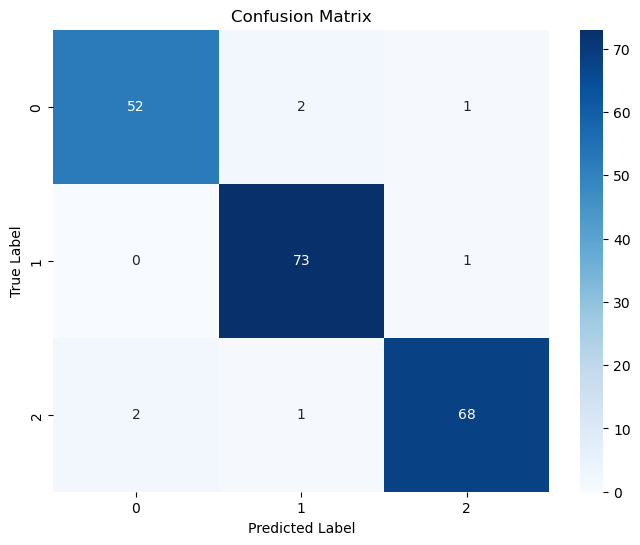

In [189]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

---

# Summary of Modeling

---

The goal of this modeling process was to predict users' primary app usage type—Social Media, Gaming, or Productivity—based on behavioral and demographic data like App Usage Hours, Age Group, and Time of Day.

We tested multiple machine learning models, focusing on Random Forest and XGBoost:

Random Forest achieved a high accuracy of 95% and provided valuable feature importance insights, making it interpretable and effective for identifying key factors influencing app usage.

XGBoost slightly outperformed Random Forest with an accuracy of 96%. Its boosted structure allowed it to capture more complex patterns, making it the optimal choice for maximizing prediction accuracy.

Ultimately, XGBoost was selected as the final model due to its superior performance and ability to handle feature interactions effectively.

Key Metrics
The final XGBoost model demonstrated high precision, recall, and F1-scores across all classes, with a strong ROC curve indicating balanced and accurate classification.

Conclusion
With an accuracy of 96%, the XGBoost model provides a reliable tool for classifying app usage types, valuable for targeted marketing, user segmentation, and understanding user engagement patterns.